In [20]:
import argparse
import os
import pandas as pd
import h5py
import numpy as np
import sys
import json
from os import environ as cuda_environment
import multiprocessing
import BM_CR_funcs as BMf

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [208]:
inputfolder = '/Users/ellenvanmaren/Desktop/Insel/EL_experiment/Codes/Cluster_scripts/Data/IO'
output_folder = os.path.join(inputfolder, "NMF_output")
files_to_process = [
        filename
        for filename in os.listdir(inputfolder)
        if filename.endswith(".csv") and filename.startswith("EL")
    ]

In [209]:
files_to_process

['EL011_con_trial.csv',
 'EL015_con_trial.csv',
 'EL005_con_trial.csv',
 'EL012_con_trial.csv',
 'EL016_con_trial.csv',
 'EL025_con_trial.csv',
 'EL021_con_trial.csv',
 'EL026_con_trial.csv',
 'EL022_con_trial.csv',
 'EL020_con_trial.csv',
 'EL019_con_trial.csv',
 'EL017_con_trial.csv',
 'EL013_con_trial.csv',
 'EL004_con_trial.csv',
 'EL014_con_trial.csv']

In [237]:
#1. Load data
filename = files_to_process[8]
print(filename)
con_trial = pd.read_csv(os.path.join(output_folder, filename.replace(".csv", "_cluster.csv")))

filename_h5 = filename.replace(".csv", "_nmf.h5")
with h5py.File(os.path.join(output_folder,filename_h5), 'r') as hf:
        # Read W and H datasets
        W = hf['W'][:]
        H = hf['H'][:]
        
filename_json = filename.replace(".csv", "_nmf_cluster.json")
with open(os.path.join(output_folder, filename_json), 'r') as json_file:
    clusters = json.load(json_file)

num_clusters = len(clusters)
con_trial['SleepState'] ='NREM1'
con_trial.loc[(con_trial.Sleep==2), 'SleepState'] ='NREM'
con_trial.loc[(con_trial.Sleep==3), 'SleepState'] ='NREM'
con_trial.loc[(con_trial.Sleep==0), 'SleepState'] ='Wake'
con_trial.loc[(con_trial.Sleep==4), 'SleepState'] ='REM'
    
con_trial = con_trial[(con_trial.SleepState!= 'NREM1')]
con_trial = con_trial.reset_index(drop=True)
con_trial.insert(5,'Cluster', 0)



EL022_con_trial.csv


## 1. Assign Stim Channel to first level cluster

In [238]:
stim_sites = np.unique(con_trial.Stim)

In [239]:
con_surr = con_trial[con_trial.Artefact == 0]
con_surr = con_surr.reset_index(drop=True)
con_surr = con_surr.drop(columns=['Artefact', 'Cluster', 'Condition', 'Hour', 'Block', 'Sleep', 'Num', 'Num_block', 'Date', 'd', 'SleepState'])
con_surr['LL_BL_norm'] = con_surr.groupby('Chan').apply(lambda x: x['LL_BL'] / x['LL_BL'].mean()).reset_index(0,
                                                                                                              drop=True)

In [240]:
n_surr = 10  # number of repetitions of surrogate testing
stim_sites = np.unique(con_trial.Stim)

# Create a list to store results for faster appending
results_list = []

# Loop over each cluster
for C_sel in clusters:
    cluster_channels = clusters[C_sel]['level1']
    for stim_chan in stim_sites:
        data_sel = con_trial.loc[(con_trial.Stim == stim_chan) & con_trial.Chan.isin(cluster_channels)]

        if not data_sel.empty:
            mean_LL = data_sel.groupby(['Int'])['LL_norm'].mean().values
            AUC = np.trapz(mean_LL, np.unique(data_sel.Int))

            AUC_surr = []
            for _ in range(n_surr):
                # Shuffle 'Int' and 'Stim' columns independently
                shuffled_data = con_surr.copy()
                # shuffled_data['Int'] = np.random.permutation(shuffled_data['Int'])
                shuffled_data['Stim'] = np.random.permutation(shuffled_data['Stim'])
                data_surr = shuffled_data[(shuffled_data.Stim == stim_chan) & shuffled_data.Chan.isin(cluster_channels)]
                mean_LL_surr = data_surr.groupby(['Int'])['LL_BL_norm'].mean().values
                AUC_surr.append(np.trapz(mean_LL_surr, np.unique(data_surr.Int)))

            thr = np.max([14,np.nanpercentile(AUC_surr, 99)])
            if AUC > thr:
                results_list.append({'Cluster': C_sel, 'Stim': stim_chan, 'AUC': AUC})

# Convert the results list to DataFrame
stim_clusters = pd.DataFrame(results_list)


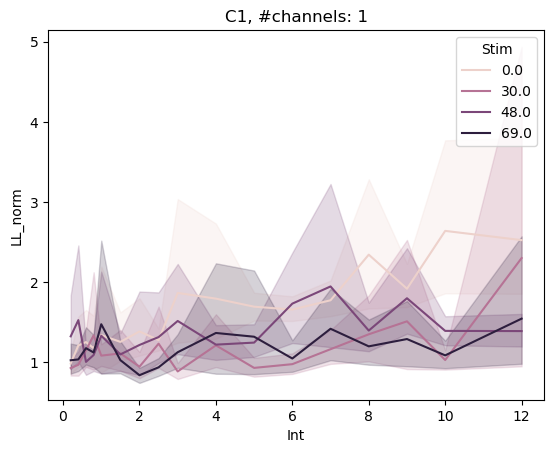

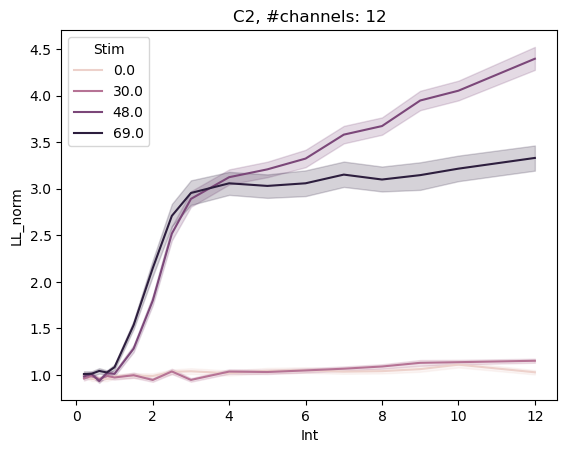

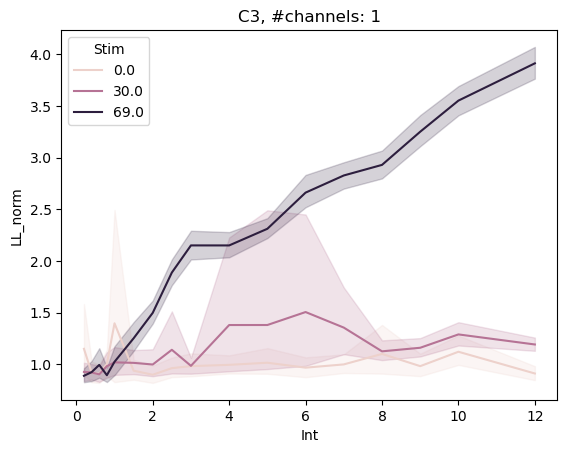

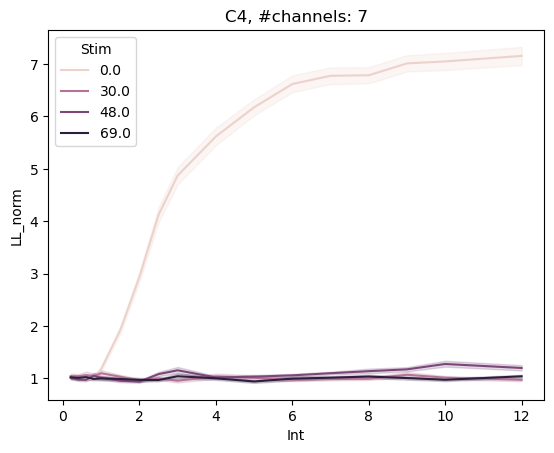

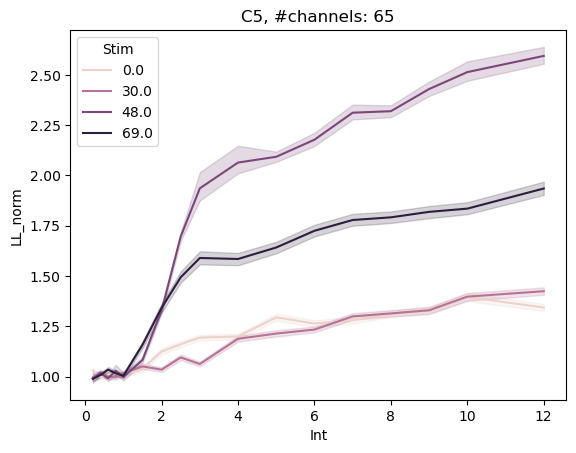

In [241]:
for c_sel in clusters:
    cluster_channels = clusters[c_sel]['level1']
    data_plot = con_trial[np.isin(con_trial.Chan, cluster_channels)]
    sns.lineplot(x='Int', y= 'LL_norm', hue = 'Stim', data = data_plot)
    plt.title(c_sel+ ', #channels: '+ str(len(cluster_channels)))
    plt.show()


In [242]:
sleepstates = np.unique(con_trial.SleepState)

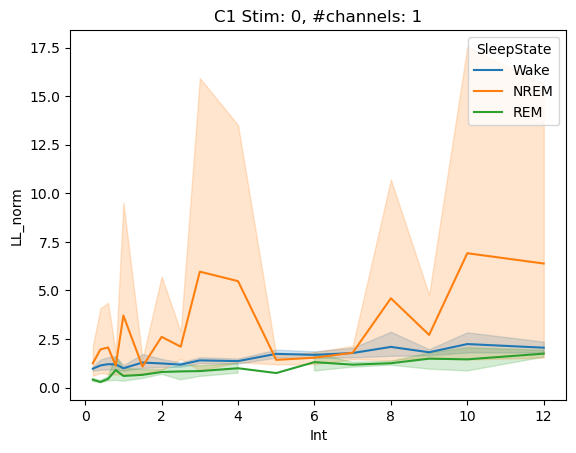

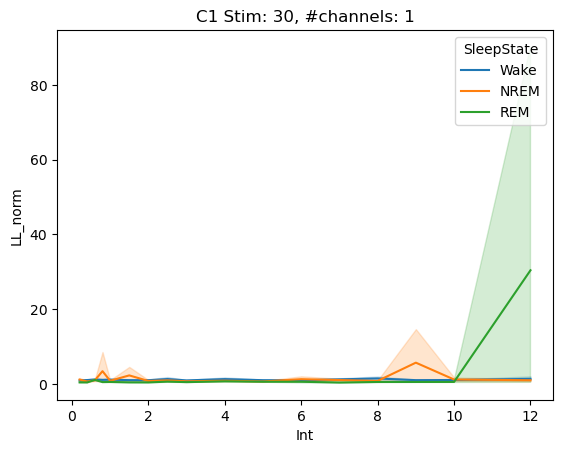

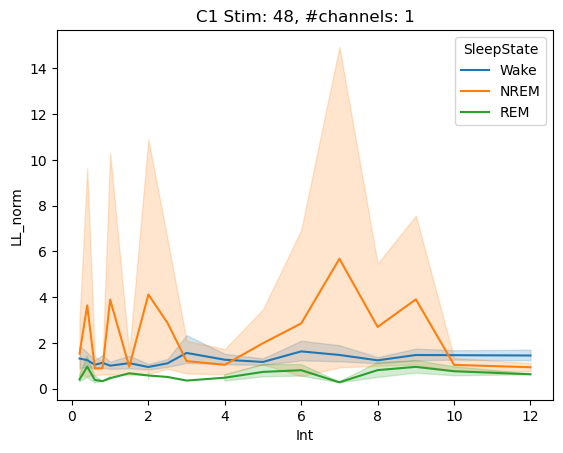

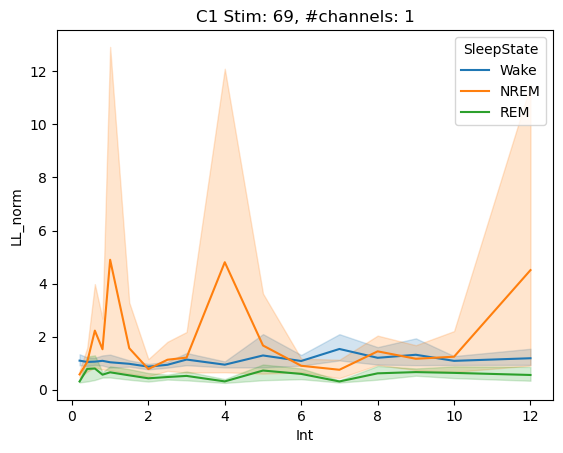

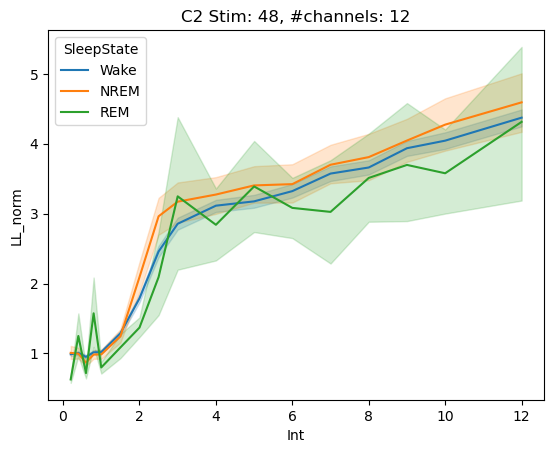

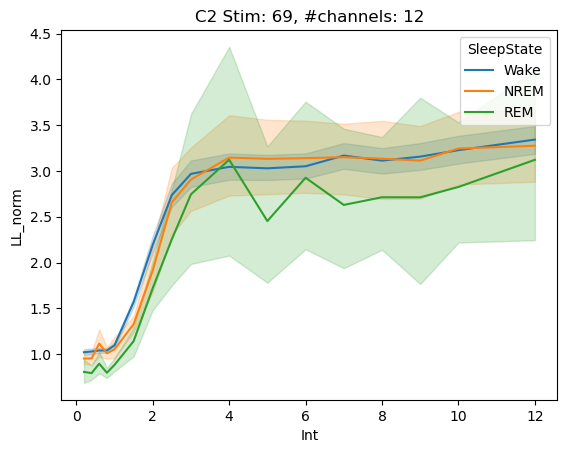

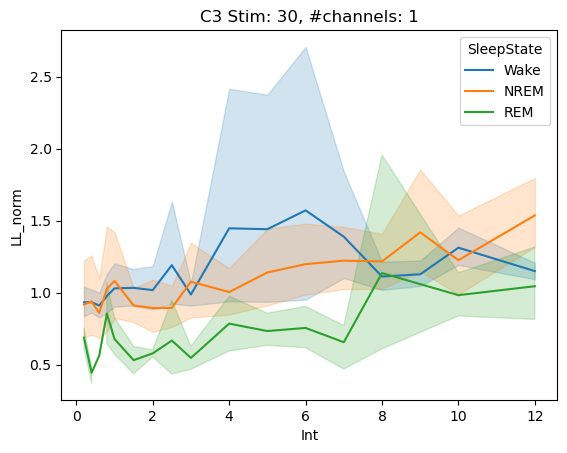

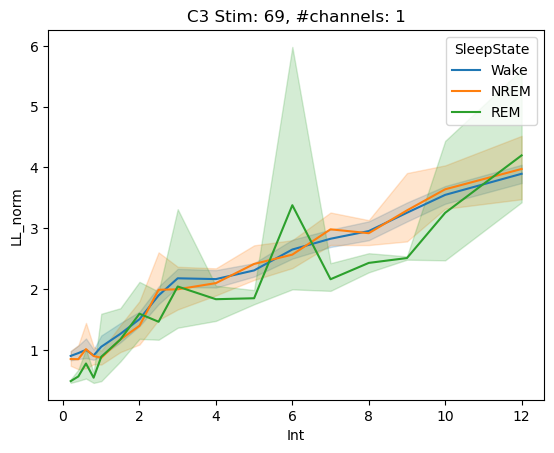

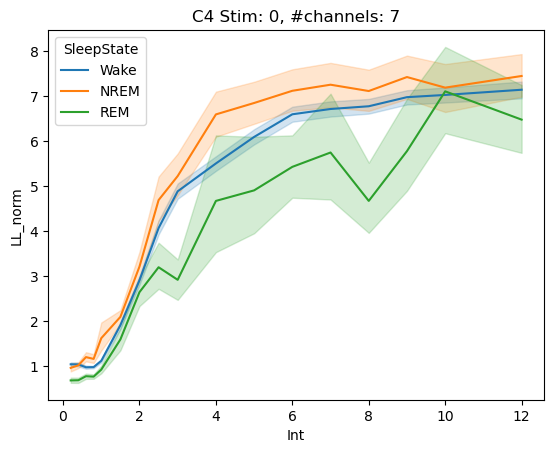

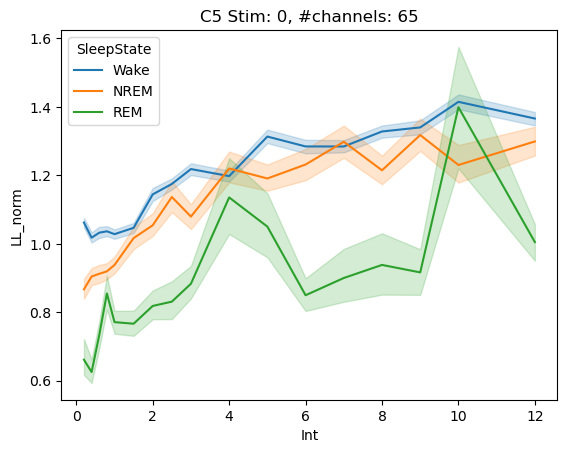

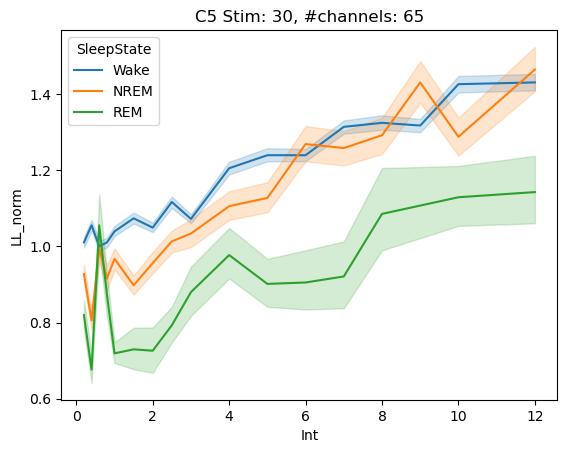

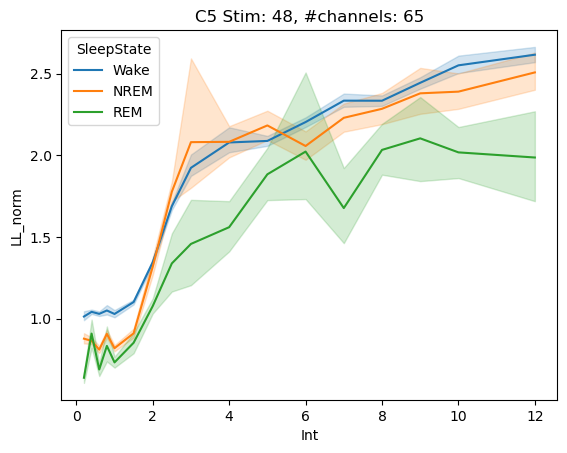

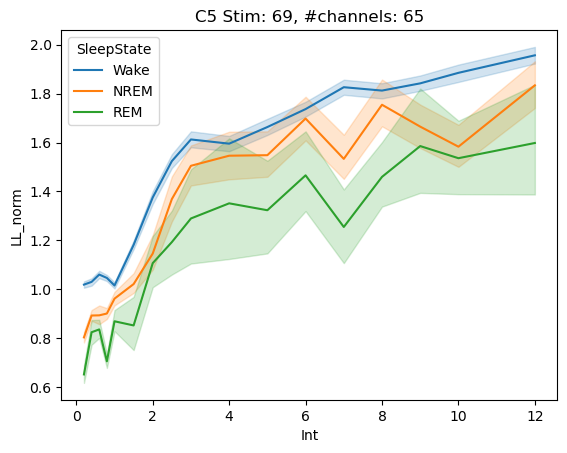

In [243]:
# Create a list to store results for faster appending
results_list = []


for _, row in stim_clusters.iterrows():
    cluster_key = row['Cluster']
    stim_chan = row['Stim']
    
    cluster_channels = clusters[cluster_key]['level1']
    data_plot = con_trial.loc[(con_trial.Stim == stim_chan) & con_trial.Chan.isin(cluster_channels)]
    sns.lineplot(x='Int', y='LL_norm', hue='SleepState', data=data_plot, hue_order=['Wake', 'NREM', 'REM'])
    plt.title(f'{cluster_key} Stim: {int(stim_chan)}, #channels: {len(cluster_channels)}')
    plt.show()


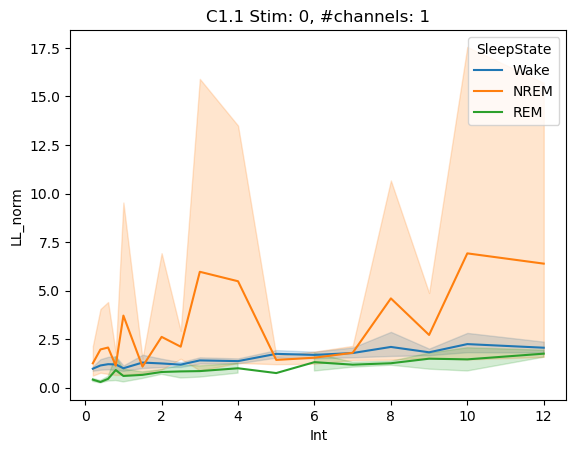

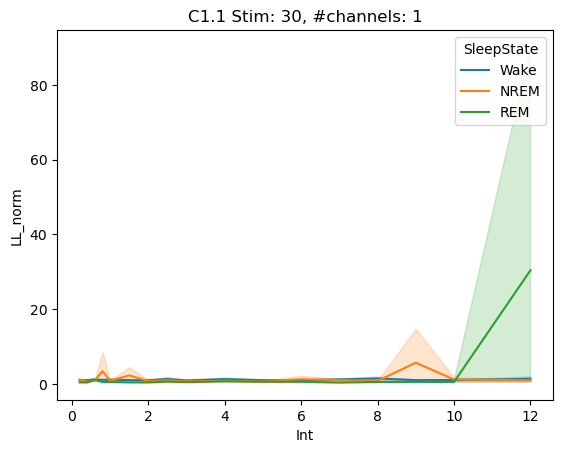

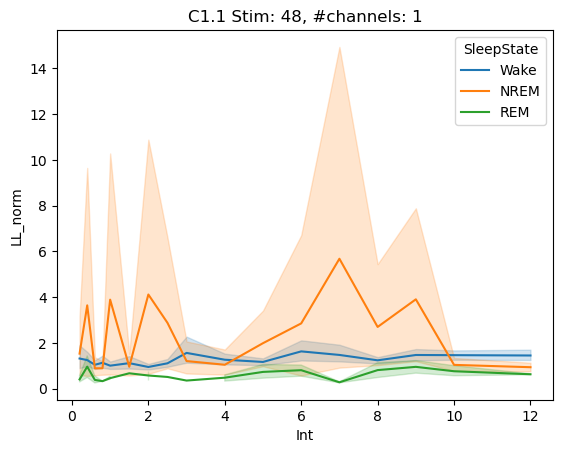

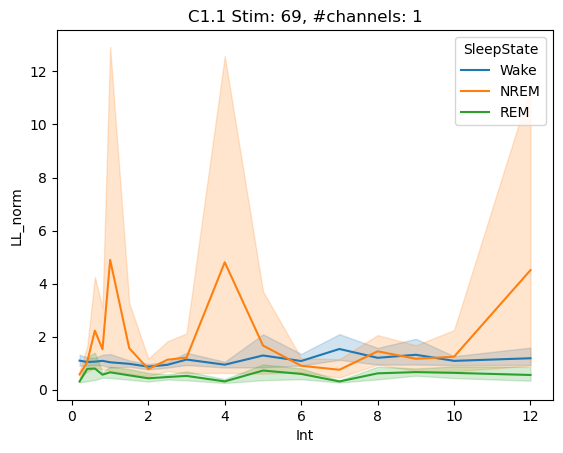

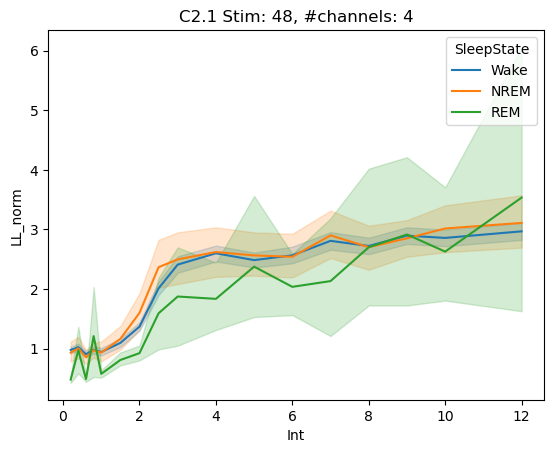

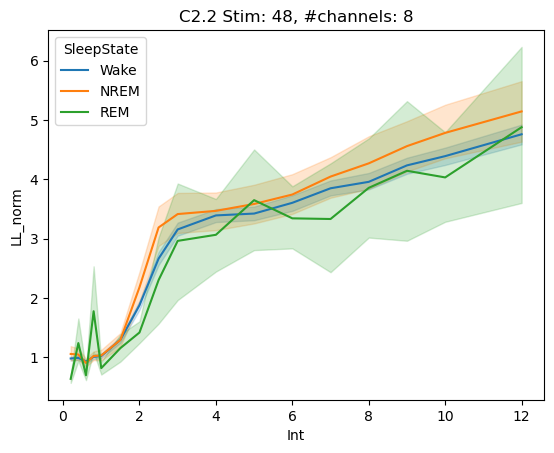

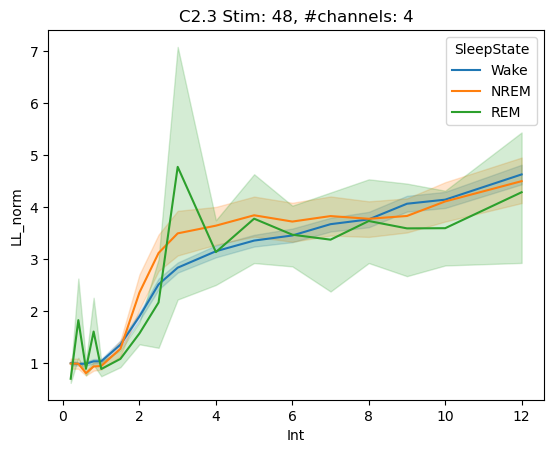

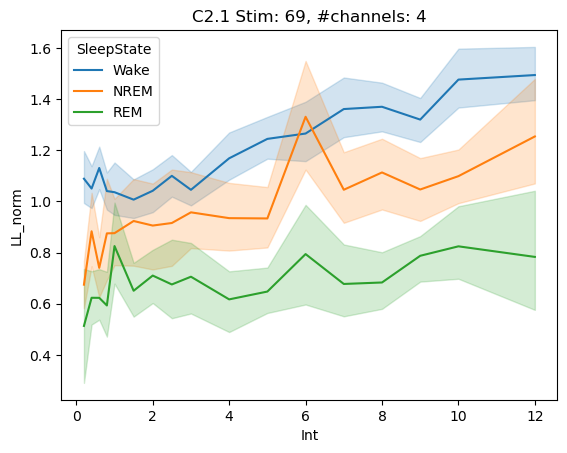

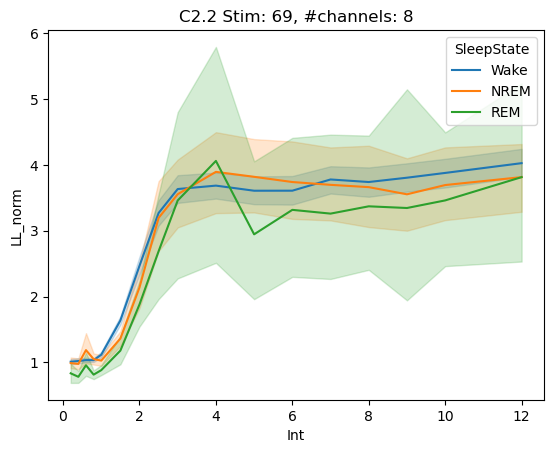

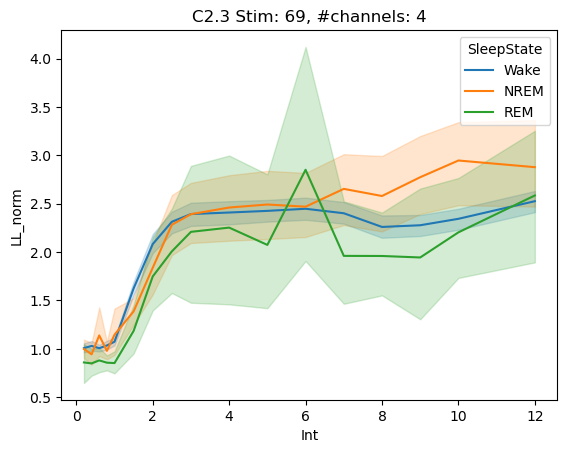

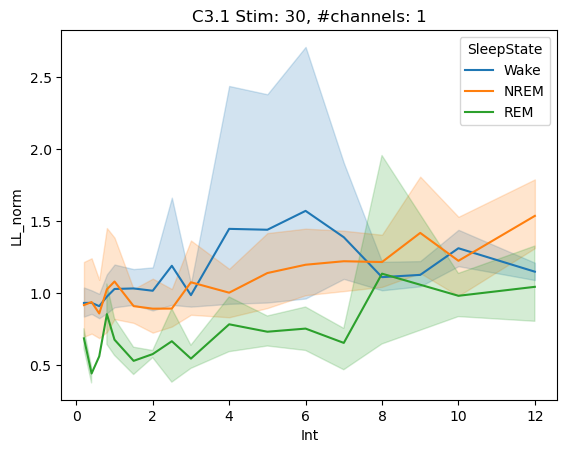

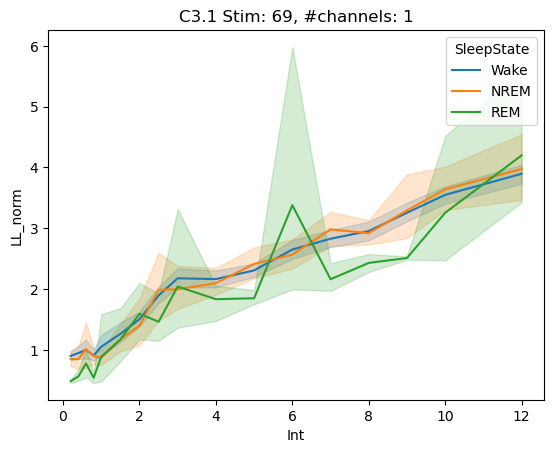

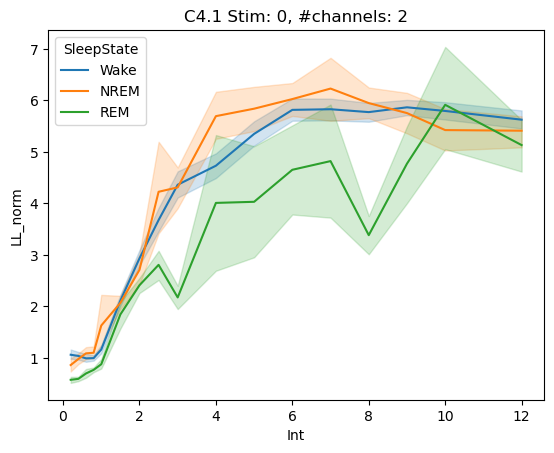

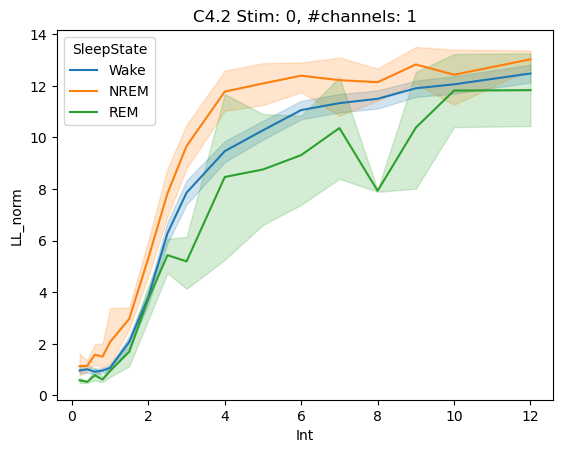

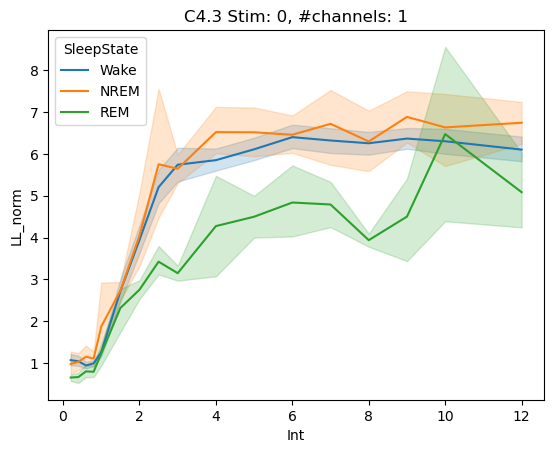

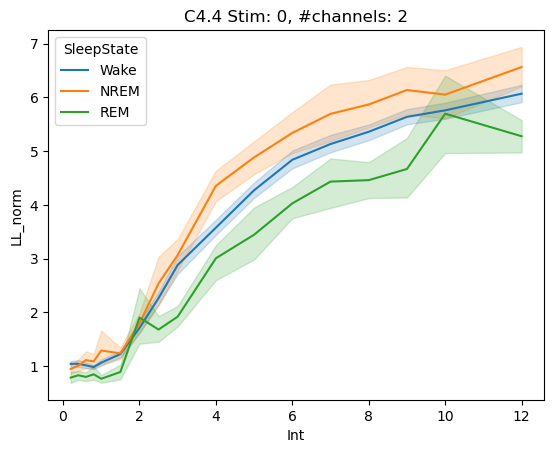

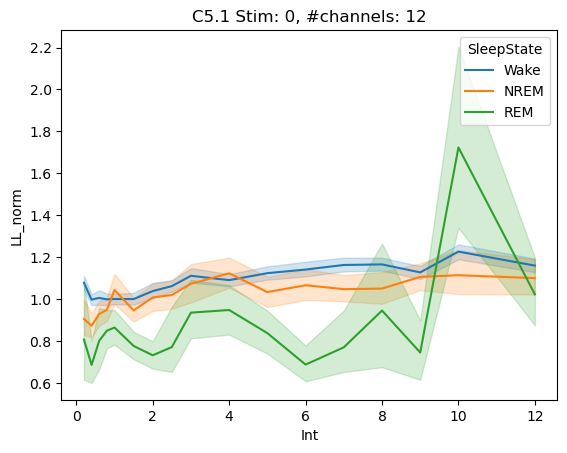

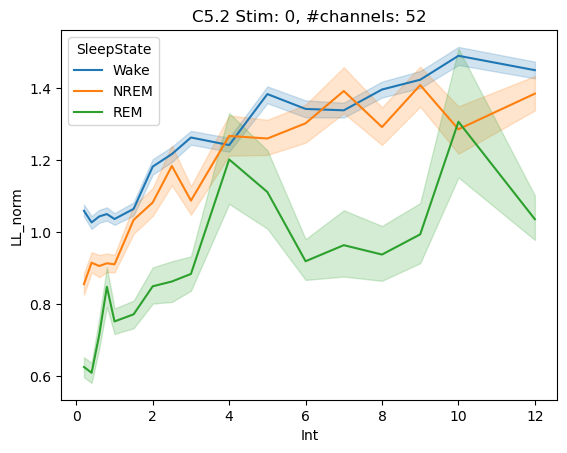

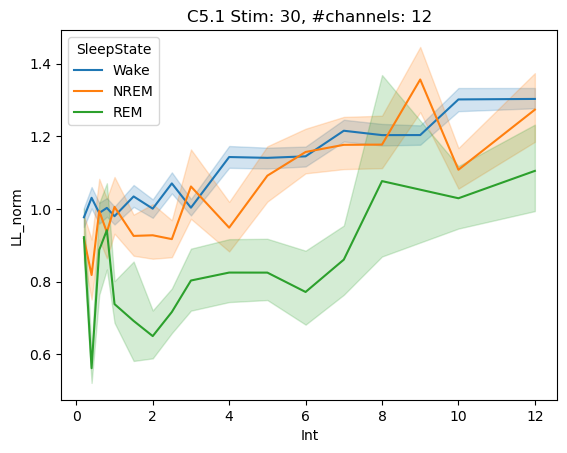

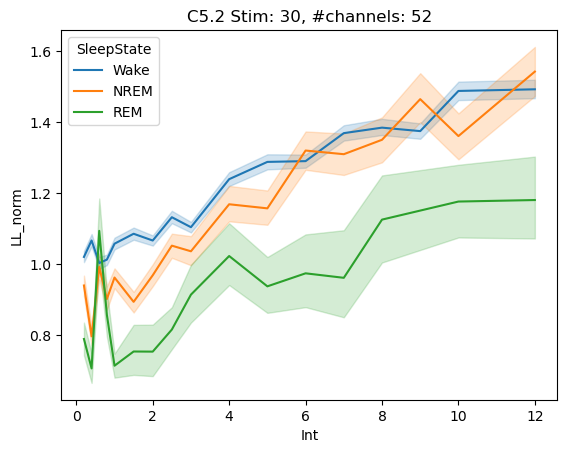

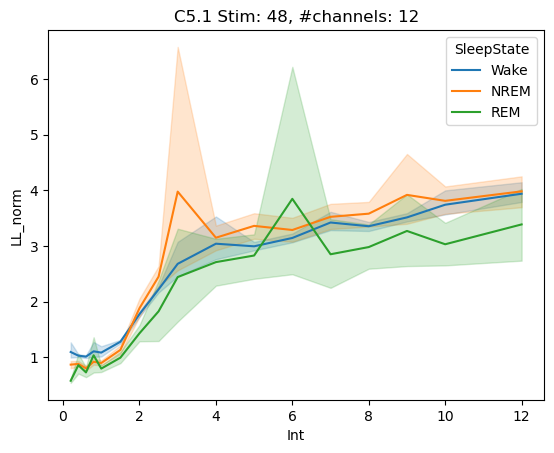

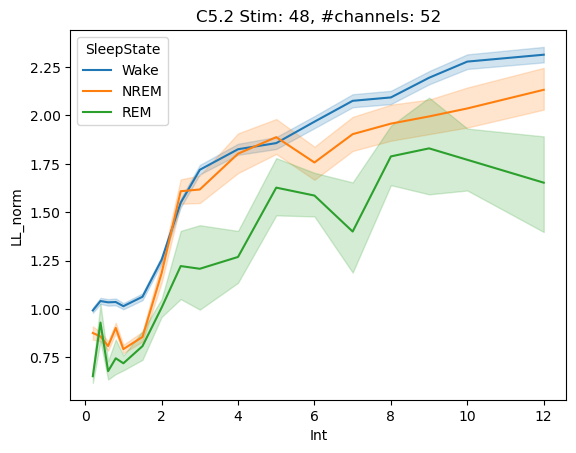

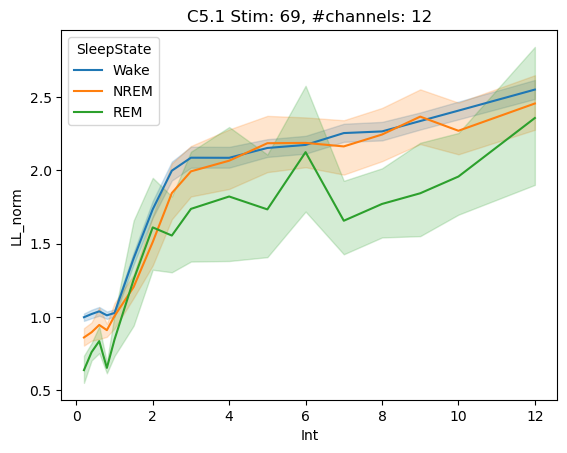

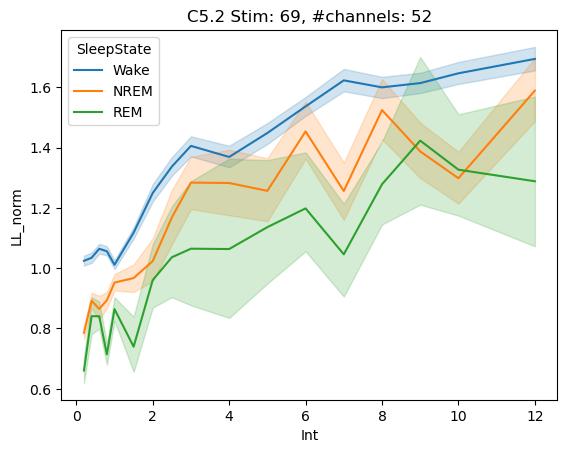

In [244]:
# Create a list to store results for faster appending
results_list = []



for _, row in stim_clusters.iterrows():
    cluster_key = row['Cluster']
    stim_chan = row['Stim']
    # Faster dictionary lookup for clusters
    level2_clusters = clusters[cluster_key]['level2']
    for c_sel2 in level2_clusters:
        if isinstance(c_sel2, int):
            cluster_channels = np.atleast_1d(c_sel2)
            label = f'{cluster_key}.1'
        else:
            cluster_channels = level2_clusters[c_sel2]
            label = c_sel2
        
        # Plotting
        data_plot = con_trial.loc[(con_trial.Stim == stim_chan) & con_trial.Chan.isin(cluster_channels)]
        sns.lineplot(x='Int', y='LL_norm', hue='SleepState', data=data_plot, hue_order=['Wake', 'NREM', 'REM'])
        plt.title(f'{label} Stim: {int(stim_chan)}, #channels: {len(cluster_channels)}')
        plt.show()
        
        # Data analysis
        for ss in ['Wake', 'NREM', 'REM']:
            data_sel = con_trial.loc[
                (con_trial.Stim == stim_chan) & con_trial.Chan.isin(cluster_channels) & (con_trial.SleepState == ss)
            ]
            mean_LL = data_sel.groupby(['Int'])['LL_norm'].mean().values
            AUC = np.trapz(mean_LL, np.unique(data_sel.Int))
            results_list.append({'Cluster': label, 'Stim': stim_chan, 'AUC': AUC, 'SleepState': ss, 'd': np.mean(data_sel.d), 'n': len(cluster_channels)})

# Convert the results list to DataFrame
subnetworks_sleep = pd.DataFrame(results_list)


# Add 'Cluster' column to the DataFrame based on the cluster assignments
for i, channels_in_cluster in clusters.items():
    data_plot = con_trial.loc[np.isin(con_trial.Con_ID, channels_in_cluster)]
    plt.figure()
    sns.stripplot(x='SleepState', y='LL_norm', data=data_plot)
    plt.show()


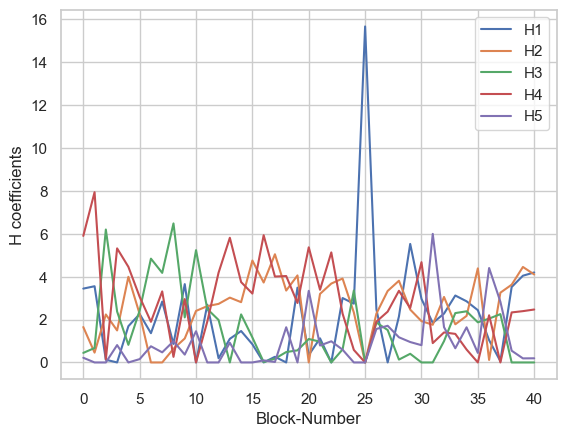

In [245]:
for i in range(H.shape[0]):
    plt.plot(H[i], label='H'+str(i+1))
    
plt.ylabel('H coefficients')
plt.xlabel('Block-Number')
plt.legend()

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [246]:
con_mean = con_trial.groupby(['Con_ID','Stim', 'Chan', 'SleepState'], as_index=False)[['Sig','d','LL_norm']].mean()

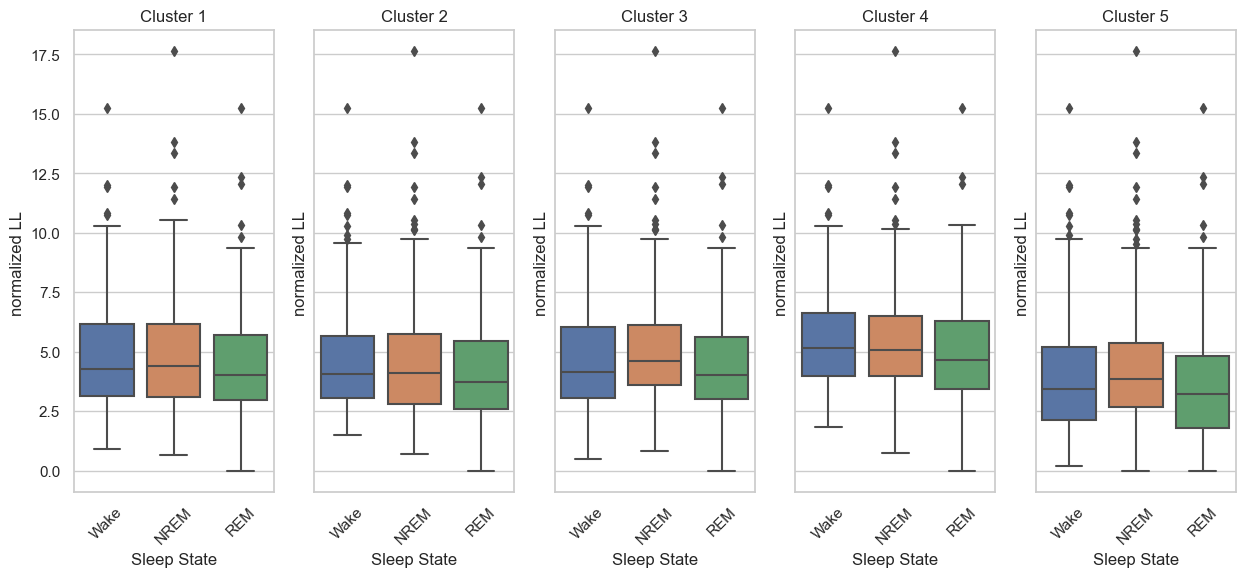

In [247]:
num_clusters = len(clusters.items())
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 6), sharey=True)

# Loop through each unique cluster to create boxplot
for i, channels_in_cluster in clusters.items():
    i = np.array(i).astype('int')
    data_plot = con_mean.loc[np.isin(con_mean.Con_ID, channels_in_cluster)]
    
    ax = sns.boxplot(x='SleepState', y='LL_norm',data=data_plot, ax=axes[i], order=['Wake', 'NREM', 'REM'])
    ax.set_title(f'Cluster {i+1}')
    ax.set_xlabel('Sleep State')
    ax.set_ylabel('normalized LL ')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #ax.set_ylim([0, 5])

[0 1 2 3 4 5]


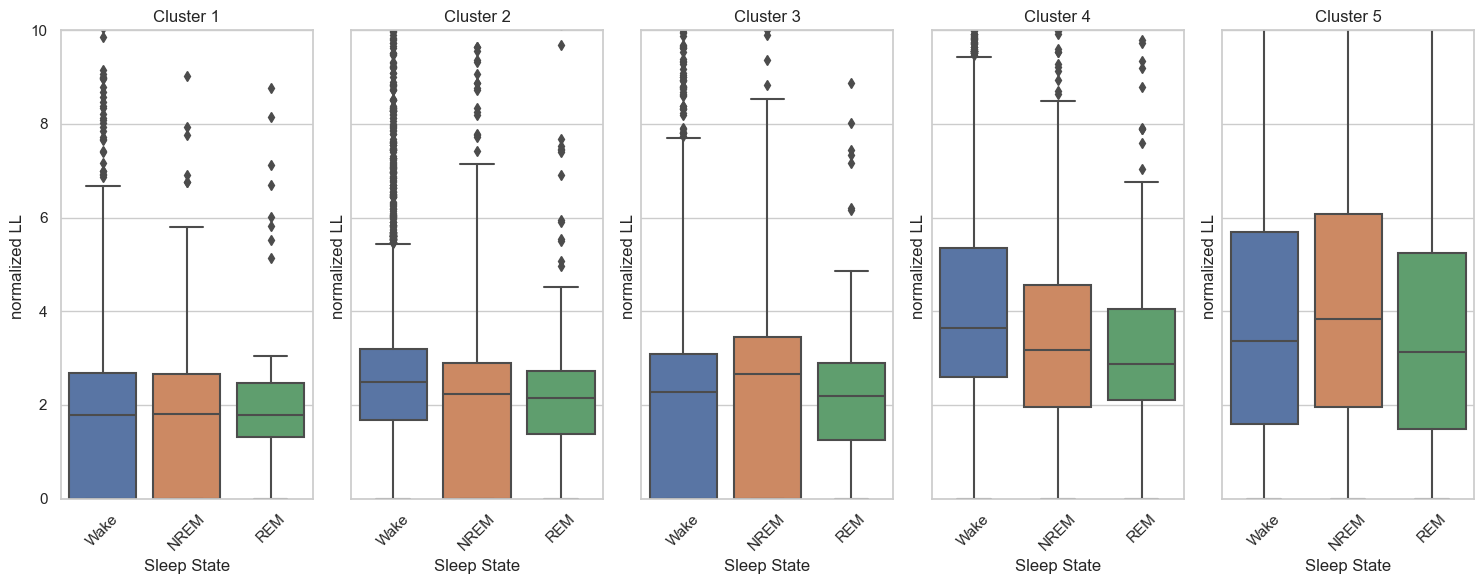

In [248]:
# Set up the plotting style
sns.set(style="whitegrid")

# Get unique cluster indices
unique_clusters = np.sort(con_trial['Cluster'].unique())
print(unique_clusters)
# Create a figure and subplots
num_clusters = len(clusters.items())
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 6), sharey=True)

# Loop through each unique cluster to create boxplot
for i, cluster_idx in enumerate(np.arange(1,num_clusters+1)):
    cluster_data = con_trial[con_trial['Cluster'] == cluster_idx]
    
    ax = sns.boxplot(x='SleepState', y='LL_norm', data=cluster_data, ax=axes[i])
    ax.set_title(f'Cluster {cluster_idx}')
    ax.set_xlabel('Sleep State')
    ax.set_ylabel('normalized LL ')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylim([0, 10])
# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()